# Comparison of TF using pykat and pytickle (qlance)

This notebook sets up a MIMO control loop to control the DARM, CARM, BS and PR degrees of freedom of an PRFPMI.

[__1.__](#overview) A detailed description of the control loop topology is given first. It is not necessary to understand this in detail before working through the example, but a general familiarity with the diagram will be useful.


In [ ]:
import numpy as np
#import pytickle.finesse as fin
#import pytickle.controls as ctrl
#import pytickle.noise as pytnoise
import scipy.signal as sig
#from pytickle.plotting import plotTF
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline
#

In [ ]:
%matplotlib widget
%matplotlib inline

In [ ]:
import pykat
#import pykat.ifo.adv as adv
import advplus as adv

                                              ..-
    PyKat 1.2.73          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [ ]:
mpl.rc('figure', figsize=(8, 11))

mpl.rcParams.update({'text.usetex': False,
                     'mathtext.fontset': 'cm',
                     'lines.linewidth': 3,
                     'lines.markersize': 10,
                     'font.size': 16,
                     'axes.grid': True,
                     'grid.alpha': 0.5,
                     'legend.loc': 'best',
                     'savefig.dpi': 80,
                     'pdf.compression': 9})

In [ ]:
pykat.info()

Pykat version: 1.2.73
Pykat loaded from: /home/enzo/anaconda3/lib/python3.8/site-packages/pykat/__init__.py
Finesse version: 2.3.1.1-g85086cec
Finesse loaded from: /home/enzo/anaconda3/bin/kat


### Include current kat file.
Remarks:

- This uses the prevous OMC parameters.
- Doess not include the mass of PR and SR.


In [ ]:
#kat = adv.make_kat(katfile='avirgo_SR_T=0_4_cold.kat', keepComments=True, preserveConstants=True)
kat = adv.make_kat(katfile='avirgo_SR_T=0_4_cold-modif.kat', keepComments=True, preserveConstants=True) # change attenuator BS for B4 PD


Pykat parsing does not preserve inline comments. Moving inline
comments before command



### Specify a working point:
 Set the power on B1 to be 5mW and find DC offset for this value

In [ ]:
#kat.IFO.find_DC_offset(4e-3, offset_type='DARM', verbose=True)

kat.IFO.find_DC_offset(5e-3, offset_type='DARM', verbose=True)

   finding DARM DC offset for AS power of 0.005 W
   starting peak search...
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 10
         Function evaluations: 20
   ... done
   DC offset for B1 = 0.005 W is: 4.912e-04 deg


0.000491

In [ ]:
# Check SR phase
kat.SR.phi

<Param (SR.phi=-89.916) at 0x7fbc404250d0>

In [ ]:
# Adjust tuning of SR to be exactly 90 deg
kat.SR.phi =-90

## Include suspensions model of Virgo:

In [ ]:
# suspensions at the Virgo site:
zs = np.array([-0.0005236+4.3982296j, -0.0005236-4.3982296j], dtype='complex64')
ps = np.array([-0.00048745+2.5132742j, -0.00050265+5.0265484j, -0.00048745-2.5132742j, -0.00050265-5.0265484j], dtype='complex64')
ks = 0.02378419

#filt_susp_1 = ctrl.Filter(zs, ps, ks, Hz = False)
#filt_susp_2 = ctrl.Filter(zs, ps, ks, Hz = True)

### Check for mass of the different mirrors:

In [ ]:
mirrors = ['NI', 'NE', 'WI', 'WE', 'BS', 'PR', 'SR']
for m in mirrors: 
    print(' THe mass of', m, 'is :', kat.components[m].mass)
    

 THe mass of NI is : 42.0
 THe mass of NE is : 42.0
 THe mass of WI is : 42.0
 THe mass of WE is : 42.0
 THe mass of BS is : 34.0
 THe mass of PR is : None
 THe mass of SR is : None


### Include suspensions model of Virgo in the kat object

In [ ]:
susp_tf = """
tf susvirgo 0.024 0 z 0.7 4200 p 0.4 2578 p 0.8 5000
attr NI zmech susvirgo mass 1 
attr NE zmech susvirgo mass 1 
attr WI zmech susvirgo mass 1 
attr WE zmech susvirgo mass 1 
attr BS zmech susvirgo mass 1 
attr PR zmech susvirgo mass 21 
attr SR zmech susvirgo mass 21 
"""

# tf:  pole-zero transfer function
# usage :
# tf name factor phase [p or z f1 Q1 [p or z f2 Q2 ...]

### Make a copy of the current kat object for further modifications

In [ ]:
kat1 = kat.deepcopy()

In [ ]:
kat1.parse(susp_tf)

### Check photodiodes used in the current object:

In [ ]:
dofs = ['DARM', 'CARM', 'MICH', 'PRCL', 'SRCL']

for dof in dofs:
    print('DARM PD:', getattr(kat1.IFO, dof).port.name, ', demodulated at:', getattr(kat1.IFO, dof).port.phase)

DARM PD: B1 , demodulated at: 0
DARM PD: B2_f1 , demodulated at: 170.1
DARM PD: B2_f2 , demodulated at: -73.8
DARM PD: B2_f3 , demodulated at: -4.5
DARM PD: B2_f2 , demodulated at: -73.8


## Check the lengths and modulation frequencies

In [ ]:
kat1.IFO.lengths_status()

 .--------------------------------------------------.
| - Arm lengths [m]:                                |
| Ln   = 2999.8000   Lw  = 2999.8000                |
| - Michelson and recycling lengths [m]:            | 
| ln   = 6.0152      lw  = 5.7851                   |
| lpr  = 6.0513      lsr  = 6.0509                  |
| lMI  = 5.9001      lSchnupp = 0.2301              |
| lPRC = 11.9515     lSRC = 11.9511                 |
+---------------------------------------------------+
| - Associated cavity frequencies [Hz]:             |
| fsrx   = 49968.74   ,    fsry = 49968.74          |
| fsrPRC = 12542050.98, fsrSRC = 12542480.59        |
| - Modulation sideband frequencies [MHz]:          |
| f1     = 6.270777    ,   f2   = 56.436993         |
| f3     = 8.361036                                 |
 +--------------------------------------------------'
| - Check frequency match:                          |
| 125.5*fsrx-300 = 6.270777 MHz                     |
| 0.5*fsrPRC = 6.271025 MHz

In [ ]:
# add yaxis for magnitud and phase in kat model:
kat1.parse("""
yaxis abs:deg
""")

In [ ]:
out1_darm = kat1.IFO.DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)

In [ ]:
kat1.IFO.DARM.scan_f??

Signature: kat1.IFO.DARM.scan_f(*args, **kwargs)
Source:   
    def scan_f(self, *args, **kwargs):
        """
        Runs an fsig simulation scaning this DOF
        
        See `pykat.ifo.scan_f` for keyword arguments options.
        """
        return scan_f(self.__IFO.kat, self, *args, **kwargs)
File:      ~/anaconda3/lib/python3.8/site-packages/pykat/ifo/__init__.py
Type:      method


### Check the direct TF of DARM

In [ ]:
ff = out1_darm.x
darm_tf = out1_darm['B1_TF']

In [ ]:
darm_tf.shape

(501,)

In [ ]:
darm_tf[0:10]

array([-9.61715387e+08+3148956.52646897j,
       -9.58858609e+08+3204704.44582142j,
       -9.55882902e+08+3260989.74702692j,
       -9.52783370e+08+3317785.39851014j,
       -9.49554921e+08+3375060.32504678j,
       -9.46192258e+08+3432778.31389095j,
       -9.42689872e+08+3490899.74602182j,
       -9.39042033e+08+3549392.56216013j,
       -9.35242783e+08+3608198.44749809j,
       -9.31285926e+08+3667275.50612003j])

In [ ]:
str(kat1.IFO.DARM.port.name)

'B1'

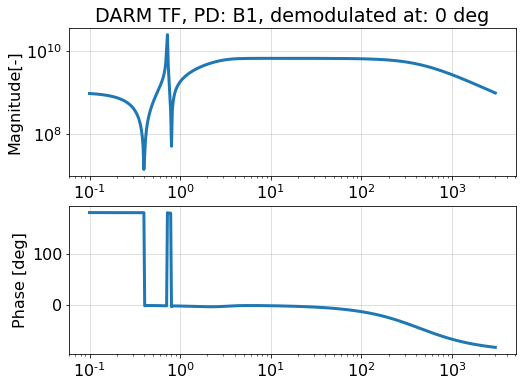

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(8, 6))
ax[0].loglog(ff, np.abs(out1_darm['B1_TF']), label ='DARM TF')
title_darm = 'DARM TF, PD: ' + str(kat1.IFO.DARM.port.name) + ', demodulated at: '+str(kat1.IFO.DARM.port.phase) + ' deg'
ax[0].set_title(title_darm)
ax[0].set_ylabel('Magnitude[-]')
ax[0].grid(True)
ax[1].semilogx(ff, np.angle(out1_darm['B1_TF'])*180/np.pi, label ='DARM TF')
ax[1].set_ylabel('Phase [deg]')
ax[1].grid(True)

## Now compute all direct TF for the main DOF:

In [ ]:
out1_darm = kat1.IFO.DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out1_carm = kat1.IFO.CARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out1_mich = kat1.IFO.MICH.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out1_prcl = kat1.IFO.PRCL.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out1_srcl = kat1.IFO.SRCL.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)

In [ ]:
ff1 = out1_carm.x
darm_tf1 = out1_darm['B1_TF']
carm_tf1 = out1_carm['B2_f1_I_TF']
mich_tf1 = out1_mich['B2_f2_Q_TF']
prcl_tf1 = out1_prcl['B2_f3_I_TF']
srcl_tf1 = out1_srcl['B2_f2_I_TF']

### Save data in a file

In [ ]:
#data_darm2darm = [ff1, darm_tf1]
#data_darm2darm = zip(*data_darm2darm)

In [ ]:
#len(ff1)

In [ ]:
## Save data:
#data_darm2darm = np.column_stack([ff1, darm_tf1])
#np.savetxt("darm2darm_test_tf.txt", data_darm2darm_2,  delimiter=' ', newline='\n', header='', footer='', comments='# ')

### Create a function to plot optical TFs

In [ ]:
def plot_tf(freq, dof_tf, DOF_name):
    title = str(DOF_name)+' TF, PD:'+str(getattr(kat1.IFO, DOF_name).port.name)+', demodulated at: '+str(getattr(kat1.IFO, DOF_name).port.phase)
    fig, ax = plt.subplots(2,1, figsize=(8, 6))
    ax[0].loglog(freq, np.abs(dof_tf), label =str(DOF_name)+' TF')
    ax[0].set_title(title)
    ax[0].set_ylabel('Magnitude')
    ax[0].grid(True)
    ax[0].legend()
    ax[1].semilogx(freq, np.angle(dof_tf)*180/np.pi, label =str(DOF_name)+' TF')
    ax[1].set_ylabel('Phase [deg]')
    ax[1].grid(True)
    ax[1].legend()

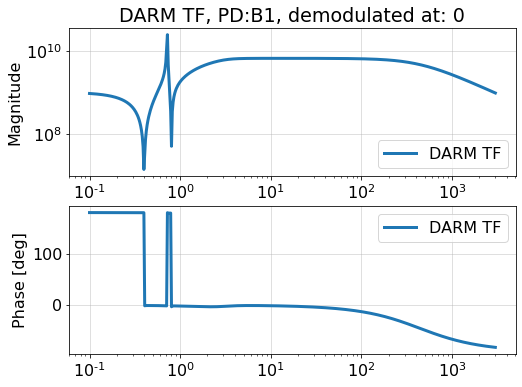

In [ ]:
# plot DARM
plot_tf(ff1, darm_tf1, 'DARM')

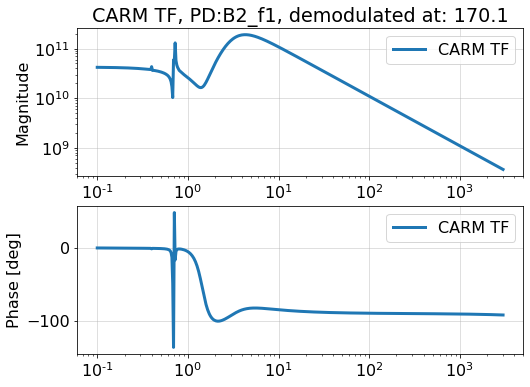

In [ ]:
# plot CARM
plot_tf(ff1, carm_tf1, 'CARM')

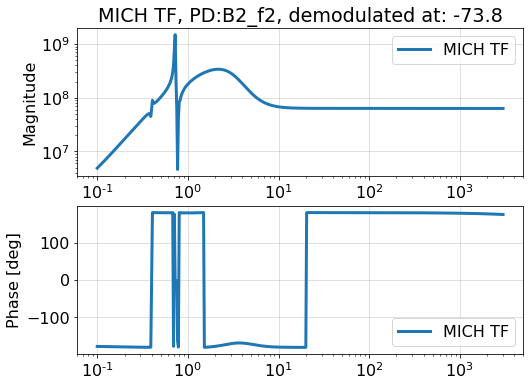

In [ ]:
# plot MICH
plot_tf(ff1, mich_tf1, 'MICH')

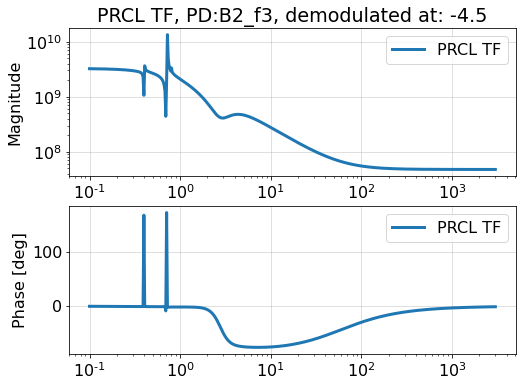

In [ ]:
# plot PRCL
plot_tf(ff1, prcl_tf1, 'PRCL')

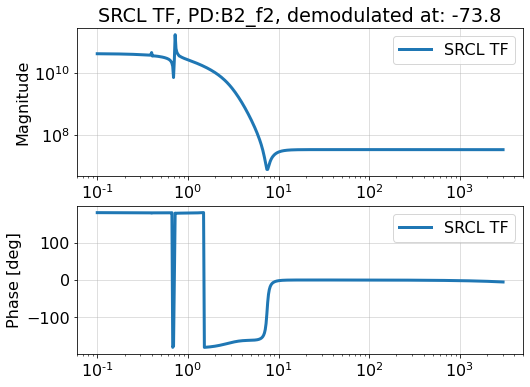

In [ ]:
# plot SRCL
plot_tf(ff1, srcl_tf1, 'SRCL')

## Optimize the demodulation phase for each DOF:

In [ ]:
# Print current demodulation phases:
dofs = ['DARM', 'CARM', 'MICH', 'PRCL', 'SRCL']

for dof in dofs:
    print('DARM PD:', getattr(kat1.IFO, dof).port.name, ', demodulated at:', getattr(kat1.IFO, dof).port.phase)

DARM PD: B1 , demodulated at: 0
DARM PD: B2_f1 , demodulated at: 170.1
DARM PD: B2_f2 , demodulated at: -73.8
DARM PD: B2_f3 , demodulated at: -4.5
DARM PD: B2_f2 , demodulated at: -73.8


## Make another copy to optimize it and compare with previous results

In [ ]:
kat2=kat1.deepcopy()

### Optimize demod phases for each DOF.

In [ ]:
for dof in dofs:
    #current = 
    if dof == 'DARM':
        print('B1 is not demodulated')
    else:
        print(str(dof)+' PD:'+str(getattr(kat2.IFO, dof).port.name)+', new demodulation phase:', pykat.ifo.optimise_demod_phase(kat2, getattr(kat2.IFO, dof), [getattr(kat2.IFO, dof).port]))

B1 is not demodulated
CARM PD:B2_f1, new demodulation phase: [170.12676057117895]
MICH PD:B2_f2, new demodulation phase: [-167.84106240822604]
PRCL PD:B2_f3, new demodulation phase: [-4.469564397006182]
SRCL PD:B2_f2, new demodulation phase: [-75.66507929708794]


### Check for max tem and gouy phase

In [ ]:
print('Maxtem:', kat2.maxtem)
print('Phase:', kat2.phase)

Maxtem: 2
Phase: 2


In [ ]:
kat2.phase??

Type:        property
String form: <property object at 0x7fbc421e9810>
Source:     
# kat2.phase.fget
@property
def phase(self): return self.__phase

# kat2.phase.fset
@phase.setter
def phase(self,value): self.__phase = int(value)


### Check order of the modulation

In [ ]:
print('Order of EOM 1:', kat2.EOM1.order)
print('Order of EOM 2:', kat2.EOM2.order)
print('Order of EOM 3:', kat2.EOM3.order)

Order of EOM 1: 1
Order of EOM 2: 1
Order of EOM 3: 1


### Adjust PRC and SRC Lengths

In [ ]:
kat2.IFO.adjust_PRC_length(verbose = True)

-- adjusting PRC length
   adusting kat.lPOP_B5.L by 0.0004736m


In [ ]:
kat2.IFO.adjust_SRC_length(verbose = True)

-- adjusting SRC length
   adusting kat.lsr.L by 0.000883m


In [ ]:
# Check lengths and mod freqs:
kat2.IFO.lengths_status()

 .--------------------------------------------------.
| - Arm lengths [m]:                                |
| Ln   = 2999.8000   Lw  = 2999.8000                |
| - Michelson and recycling lengths [m]:            | 
| ln   = 6.0152      lw  = 5.7851                   |
| lpr  = 6.0518      lsr  = 6.0518                  |
| lMI  = 5.9001      lSchnupp = 0.2301              |
| lPRC = 11.9520     lSRC = 11.9520                 |
+---------------------------------------------------+
| - Associated cavity frequencies [Hz]:             |
| fsrx   = 49968.74   ,    fsry = 49968.74          |
| fsrPRC = 12541554.00, fsrSRC = 12541554.00        |
| - Modulation sideband frequencies [MHz]:          |
| f1     = 6.270777    ,   f2   = 56.436993         |
| f3     = 8.361036                                 |
 +--------------------------------------------------'
| - Check frequency match:                          |
| 125.5*fsrx-300 = 6.270777 MHz                     |
| 0.5*fsrPRC = 6.270777 MHz

### Check demodulation frequencies of the different DOF

In [ ]:
for dof in dofs:
    print(str(dof),' PD demod freq:', getattr(kat1.IFO, dof).port.f)

DARM  PD demod freq: None
CARM  PD demod freq: 6270777.0
MICH  PD demod freq: 56436993.0
PRCL  PD demod freq: 8361036.0
SRCL  PD demod freq: 56436993.0


### One can get the error signals:

In [ ]:
kat2.IFO.add_errsigs_block(verbose=True)

 .--------------------------------------------------
 | error signals:                                   
 +--------------------------------------------------
 | PRCL: pd1 B2_f3_I 8361036.0 -4.469564397006182 nB2
 | MICH: pd1 B2_f2_Q 56436993.0 14.334920702912058 nB2
 | CARM: pd1 B2_f1_I 6270777.0 170.12676057117895 nB2
 | DARM: pd B1 nB1                                   
 | SRCL: pd1 B2_f2_I 56436993.0 -75.66507929708794 nB2
 `--------------------------------------------------


'pd1 B2_f3_I 8361036.0 -4.469564397006182 nB2\npd1 B2_f2_Q 56436993.0 14.334920702912058 nB2\npd1 B2_f1_I 6270777.0 170.12676057117895 nB2\npd B1 nB1\npd1 B2_f2_I 56436993.0 -75.66507929708794 nB2\n'

## Now compute again the Optical TFs:

In [ ]:
out2_darm = kat2.IFO.DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out2_carm = kat2.IFO.CARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out2_mich = kat2.IFO.MICH.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out2_prcl = kat2.IFO.PRCL.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out2_srcl = kat2.IFO.SRCL.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)

In [ ]:
ff2 = out2_darm.x
darm_tf2 = out2_darm['B1_TF']
carm_tf2 = out2_carm['B2_f1_I_TF']
mich_tf2 = out2_mich['B2_f2_Q_TF']
prcl_tf2 = out2_prcl['B2_f3_I_TF']
srcl_tf2 = out2_srcl['B2_f2_I_TF']

### Plot together the results of the 2 simulations

In [ ]:
# Function to plot 2 tf together
def plot_2_tfs(freq1, dof_tf1, freq2, dof_tf2, DOF_name):
    title = str(DOF_name)+' TF, PD:'+str(getattr(kat2.IFO, DOF_name).port.name)+', demodulated at: '+str(getattr(kat2.IFO, DOF_name).port.phase)
    fig, ax = plt.subplots(2,1, figsize=(8, 6))
    ax[0].loglog(freq1, np.abs(dof_tf1), label =str(DOF_name)+' TF')
    ax[0].loglog(freq2, np.abs(dof_tf2), '--', label =str(DOF_name)+' TF optimized')
    ax[0].set_title(title)
    ax[0].set_ylabel('Magnitude')
    ax[0].grid(True)
    ax[0].legend()
    ax[1].semilogx(freq1, np.angle(dof_tf1)*180/np.pi, label =str(DOF_name)+' TF')
    ax[1].semilogx(freq2, np.angle(dof_tf2)*180/np.pi, '--', label =str(DOF_name)+' TF optimized')
    ax[1].set_ylabel('Phase [deg]')
    ax[1].grid(True)
    ax[1].legend()

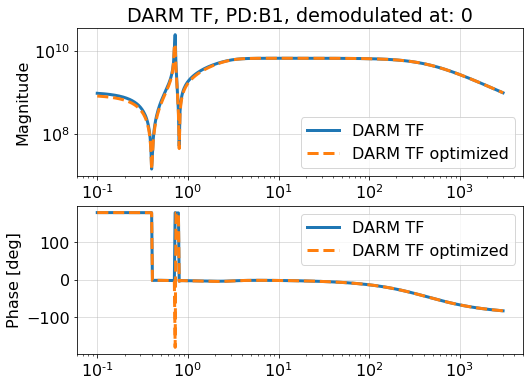

In [ ]:
plot_2_tfs(ff1, darm_tf1, ff2, darm_tf2, 'DARM')

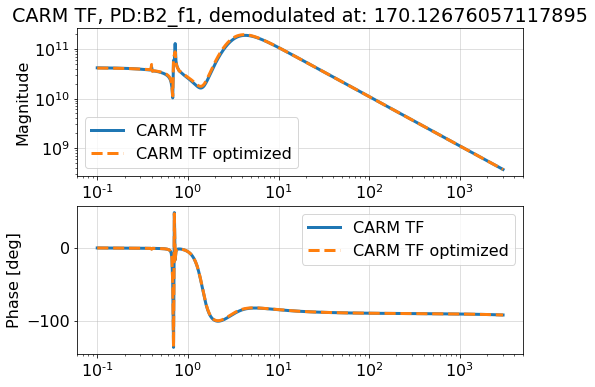

In [ ]:
plot_2_tfs(ff1, carm_tf1, ff2, carm_tf2, 'CARM')

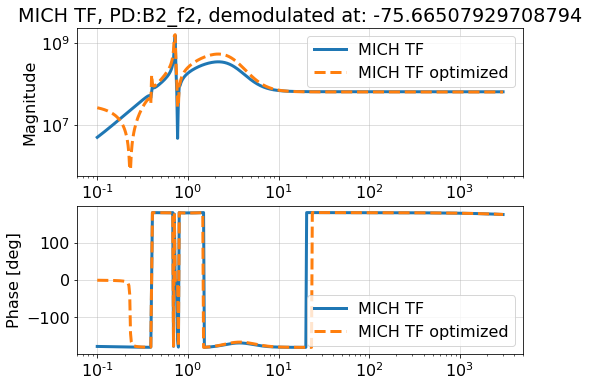

In [ ]:
plot_2_tfs(ff1, mich_tf1, ff2, mich_tf2, 'MICH')

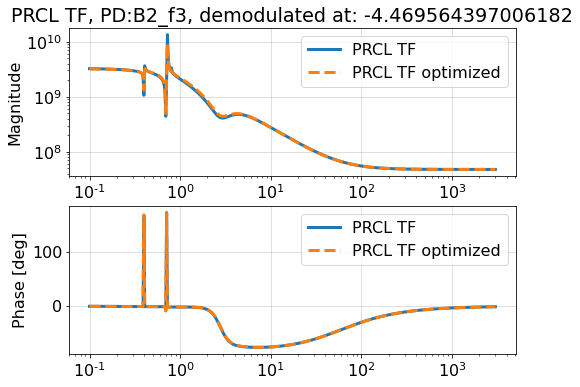

In [ ]:
plot_2_tfs(ff1, prcl_tf1, ff2, prcl_tf2, 'PRCL')

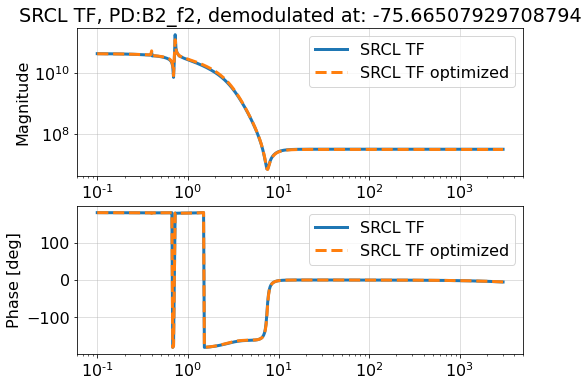

In [ ]:
plot_2_tfs(ff1, srcl_tf1, ff2, srcl_tf2, 'SRCL')

### --------------------- --------------------- --------------------- --------------------- --------------------- --------------------- ---------------------

### Save data

In [ ]:
# Create a function to save data:

def save_data(filename, freq, frd):
    #file_name = str(filename)+'.txt'
    file = open(filename,'w')
    for val in zip(freq, frd):
        file.write('{} {}\n'.format(val[0], val[1]))
    file.close()

#powdata=open("powdata.txt","w")
#for val in zip(ff3, carm2darm_tf):
#    powdata.write('{} {}\n'.format(val[0], val[1]))
#powdata.close()

In [ ]:
save_data('darm2darm_tf.txt', ff2, darm_tf2)
save_data('carm2carm_tf.txt', ff2, carm_tf2)
save_data('mich2mich_tf.txt', ff2, mich_tf2)
save_data('prcl2prcl_tf.txt', ff2, prcl_tf2)
save_data('srcl2srcl_tf.txt', ff2, srcl_tf2)

## Now let's create some DOFs to compute the crosscoupling terms:

In [ ]:
kat3 = kat2.deepcopy()

In [ ]:
kat3.IFO.DOFs

{'CARM': <pykat.ifo.DOF at 0x7fbc3eff8b20>,
 'CHARD_P': <pykat.ifo.DOF at 0x7fbc3eff8be0>,
 'CSOFT_P': <pykat.ifo.DOF at 0x7fbc3eff8c40>,
 'DARM': <pykat.ifo.DOF at 0x7fbc3eff8b50>,
 'DARM_h': <pykat.ifo.DOF at 0x7fbc3eff8b80>,
 'DHARD_P': <pykat.ifo.DOF at 0x7fbc3eff8c10>,
 'DSOFT_P': <pykat.ifo.DOF at 0x7fbc3eff8c70>,
 'MICH': <pykat.ifo.DOF at 0x7fbc3eff8af0>,
 'MICH_P': <pykat.ifo.DOF at 0x7fbc3eff8d00>,
 'PRCL': <pykat.ifo.DOF at 0x7fbc3eff8ac0>,
 'PR_P': <pykat.ifo.DOF at 0x7fbc3eff8ca0>,
 'SRCL': <pykat.ifo.DOF at 0x7fbc3eff8bb0>,
 'SR_P': <pykat.ifo.DOF at 0x7fbc3eff8cd0>,
 'preARMN': <pykat.ifo.DOF at 0x7fbc3eff8970>,
 'preARMW': <pykat.ifo.DOF at 0x7fbc3eff89a0>,
 'preCARM': <pykat.ifo.DOF at 0x7fbc3eff8a60>,
 'preDARM': <pykat.ifo.DOF at 0x7fbc3eff8a30>,
 'preMICH': <pykat.ifo.DOF at 0x7fbc3eff89d0>,
 'prePRCL': <pykat.ifo.DOF at 0x7fbc3eff8a00>,
 'preSRCL': <pykat.ifo.DOF at 0x7fbc3eff8a90>}

In [ ]:
kat3.IFO.mirrors


['NE',
 'NI',
 'NIAR',
 'WE',
 'WI',
 'WIAR',
 'PR',
 'PRAR',
 'SR',
 'SRAR',
 'BS',
 'BSAR1',
 'BSAR2']

In [ ]:
kat3.IFO.Outputs

{'B1': <pykat.ifo.Output at 0x7fbc3eff8730>,
 'B1p': <pykat.ifo.Output at 0x7fbc3eff8760>,
 'B1p_f2': <pykat.ifo.Output at 0x7fbc3eff8790>,
 'B2_f1': <pykat.ifo.Output at 0x7fbc3eff87c0>,
 'B2_f2': <pykat.ifo.Output at 0x7fbc3eff87f0>,
 'B2_f3': <pykat.ifo.Output at 0x7fbc3eff8820>,
 'B4_f1': <pykat.ifo.Output at 0x7fbc3eff8850>,
 'B4_f2': <pykat.ifo.Output at 0x7fbc3eff8880>,
 'POW_BS': <pykat.ifo.Output at 0x7fbc3eff88b0>,
 'POW_S': <pykat.ifo.Output at 0x7fbc3eff8940>,
 'POW_X': <pykat.ifo.Output at 0x7fbc3eff88e0>,
 'POW_Y': <pykat.ifo.Output at 0x7fbc3eff8910>}

In [ ]:
# Check the error signals:
kat3.IFO.add_errsigs_block(verbose=True)

 .--------------------------------------------------
 | error signals:                                   
 +--------------------------------------------------
 | PRCL: pd1 B2_f3_I 8361036.0 -4.469564397006182 nB2
 | MICH: pd1 B2_f2_Q 56436993.0 14.334920702912058 nB2
 | CARM: pd1 B2_f1_I 6270777.0 170.12676057117895 nB2
 | DARM: pd B1 nB1                                   
 | SRCL: pd1 B2_f2_I 56436993.0 -75.66507929708794 nB2
 `--------------------------------------------------


'pd1 B2_f3_I 8361036.0 -4.469564397006182 nB2\npd1 B2_f2_Q 56436993.0 14.334920702912058 nB2\npd1 B2_f1_I 6270777.0 170.12676057117895 nB2\npd B1 nB1\npd1 B2_f2_I 56436993.0 -75.66507929708794 nB2\n'

In [ ]:
kat3.IFO.DARM.factors

[-1, 1]

In [ ]:
kat3.IFO.DARM.optics

['NE', 'WE']

In [ ]:
kat.IFO.CARM.port.name

'B2_f1'

In [ ]:
kat.IFO.CARM.quad

'I'

In [ ]:
kat.IFO.CARM.scale

1.5

### Create crosscoupling terms:
    1. From DARM to any other DOF
    2. From CARM to any other DOF
    3. From MICH to any other DOF
    4. From PRCL to any other DOF
    5. From SRCL to any other DOF

In [ ]:
# 1. From DARM to any other DOF.
kat3.IFO.DARM2CARM_test =  adv.DOF(kat3.IFO, "DARM2CARM_test", kat3.IFO.B2_f1, "I", ['NE', 'WE'], [-1, 1], 1.5, sigtype="z")

kat3.IFO.DARM2CARM =  adv.DOF(kat3.IFO, "DARM2CARM", getattr(kat3.IFO, kat3.IFO.CARM.port.name), kat3.IFO.CARM.quad, kat3.IFO.DARM.optics, kat3.IFO.DARM.factors, kat3.IFO.DARM.scale, sigtype="z")
kat3.IFO.DARM2MICH =  adv.DOF(kat3.IFO, "DARM2MICH", getattr(kat3.IFO, kat3.IFO.MICH.port.name), kat3.IFO.MICH.quad, kat3.IFO.DARM.optics, kat3.IFO.DARM.factors, kat3.IFO.DARM.scale, sigtype="z")
kat3.IFO.DARM2PRCL =  adv.DOF(kat3.IFO, "DARM2PRCL", getattr(kat3.IFO, kat3.IFO.PRCL.port.name), kat3.IFO.PRCL.quad, kat3.IFO.DARM.optics, kat3.IFO.DARM.factors, kat3.IFO.DARM.scale, sigtype="z")
kat3.IFO.DARM2SRCL =  adv.DOF(kat3.IFO, "DARM2SRCL", getattr(kat3.IFO, kat3.IFO.SRCL.port.name), kat3.IFO.SRCL.quad, kat3.IFO.DARM.optics, kat3.IFO.DARM.factors, kat3.IFO.DARM.scale, sigtype="z")


### But which scale?

Scale corresponds to the DOF that is being moved.

In [ ]:
adv.DOF??

Init signature:
adv.DOF(
    IFO,
    _DOFName,
    _port,
    _quad,
    _optics,
    _factors,
    _scale,
    sigtype='z',
)
Source:        
class DOF(object):
    """
    Defining a degree of freedom for the interferometer, includes the
    objects and how to move them, and the default output port to read
    out the DOF signal.
    """
    def __init__(self, IFO, _DOFName, _port, _quad, _optics, _factors, _scale, sigtype="z"):
        self.__IFO = IFO
        self.name = _DOFName
        self.port = _port
        self.quad = _quad
        self.sigtype = sigtype
        self.optics=make_list_copy(_optics)
        self.factors=make_list_copy(_factors)

        # scaling factor, to compensate for lower sensitivity compared
        # to DARM (in tuning plots for example)
        # Thus DARM has a scale of 1, all other DOFs a scale >1
        self.scale = _scale
    
    def _mirror_target(self):
        """
        Returns which parameter to target in puts and xaxis depending on sigty

In [ ]:
out_darm2carm_test = kat3.IFO.DARM2CARM_test.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
#out_darm2carm = kat3.IFO.DARM2CARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)

In [ ]:
out_darm2carm = kat3.IFO.DARM2CARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_darm2mich = kat3.IFO.DARM2MICH.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_darm2prcl = kat3.IFO.DARM2PRCL.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_darm2srcl = kat3.IFO.DARM2SRCL.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)

In [ ]:
# Check error signals again:
kat3.IFO.add_errsigs_block(verbose=True)

 .--------------------------------------------------
 | error signals:                                   
 +--------------------------------------------------
 | PRCL: pd1 B2_f3_I 8361036.0 -4.469564397006182 nB2
 | MICH: pd1 B2_f2_Q 56436993.0 14.334920702912058 nB2
 | CARM: pd1 B2_f1_I 6270777.0 170.12676057117895 nB2
 | DARM: pd B1 nB1                                   
 | SRCL: pd1 B2_f2_I 56436993.0 -75.66507929708794 nB2
 `--------------------------------------------------


'pd1 B2_f3_I 8361036.0 -4.469564397006182 nB2\npd1 B2_f2_Q 56436993.0 14.334920702912058 nB2\npd1 B2_f1_I 6270777.0 170.12676057117895 nB2\npd B1 nB1\npd1 B2_f2_I 56436993.0 -75.66507929708794 nB2\n'

In [ ]:
ff3 = out_darm2carm_test.x
darm2carm_test_tf = out_darm2carm_test['B2_f1_I_TF']

darm2carm_tf = out_darm2carm['B2_f1_I_TF']
darm2mich_tf = out_darm2mich['B2_f2_Q_TF']
darm2prcl_tf = out_darm2prcl['B2_f3_I_TF']
darm2srcl_tf = out_darm2srcl['B2_f2_I_TF']


### Save data:

In [ ]:
save_data('darm2carm_tf.txt', ff3, darm2carm_tf)
save_data("darm2mich_tf.txt", ff3, darm2mich_tf)
save_data("darm2prcl_tf.txt", ff3, darm2prcl_tf)
save_data("darm2srcl_tf.txt", ff3, darm2srcl_tf)

In [ ]:
def plot_tf_kat(freq, dof_tf, DOF_name, kat_object):
    title = str(DOF_name)+' TF, PD:'+str(getattr(kat_object.IFO, DOF_name).port.name)+', demodulated at: '+str(getattr(kat_object.IFO, DOF_name).port.phase)
    fig, ax = plt.subplots(2,1, figsize=(8, 6))
    ax[0].loglog(freq, np.abs(dof_tf), label =str(DOF_name)+' TF')
    ax[0].set_title(title)
    ax[0].set_ylabel('Magnitude')
    ax[0].grid(True)
    ax[0].legend()
    ax[1].semilogx(freq, np.angle(dof_tf)*180/np.pi, label =str(DOF_name)+' TF')
    ax[1].set_ylabel('Phase [deg]')
    ax[1].grid(True)
    ax[1].legend()

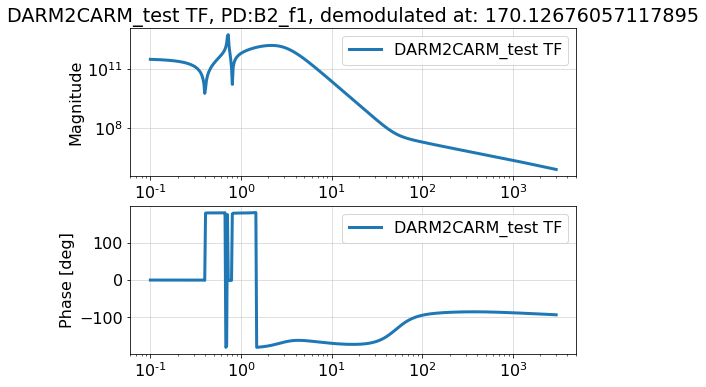

In [ ]:
plot_tf_kat(ff3, darm2carm_test_tf, 'DARM2CARM_test', kat3)

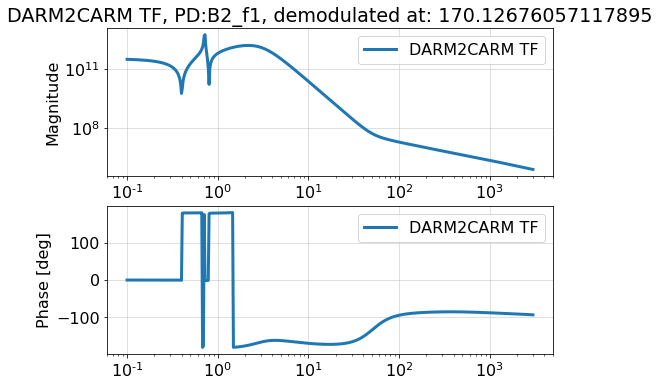

In [ ]:
plot_tf_kat(ff3, darm2carm_tf, 'DARM2CARM', kat3)

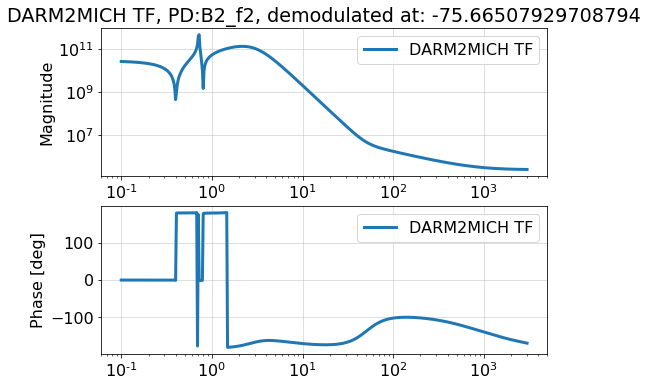

In [ ]:
plot_tf_kat(ff3, darm2mich_tf, 'DARM2MICH', kat3)

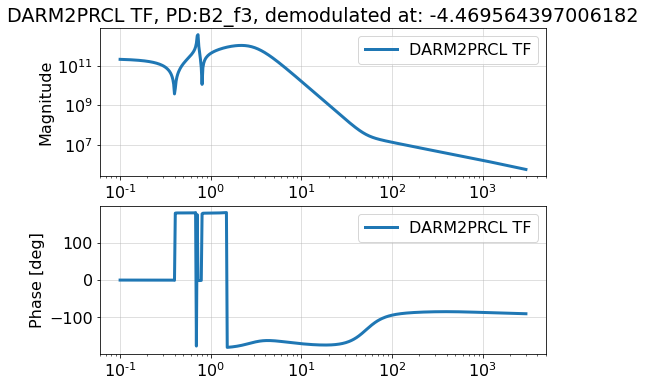

In [ ]:
plot_tf_kat(ff3, darm2prcl_tf, 'DARM2PRCL', kat3)

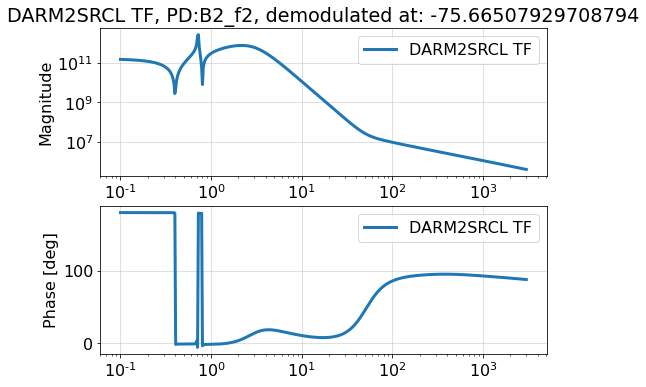

In [ ]:
plot_tf_kat(ff3, darm2srcl_tf, 'DARM2SRCL', kat3)

In [ ]:
kat3.IFO.DARM.port.name

'B1'

In [ ]:
# 2. From CARM to any other DOF.
kat3.IFO.CARM2DARM =  adv.DOF(kat3.IFO, "CARM2DARM", getattr(kat3.IFO, kat3.IFO.DARM.port.name), kat3.IFO.DARM.quad, kat3.IFO.CARM.optics, kat3.IFO.CARM.factors, kat3.IFO.CARM.scale, sigtype="z")
kat3.IFO.CARM2MICH =  adv.DOF(kat3.IFO, "CARM2MICH", getattr(kat3.IFO, kat3.IFO.MICH.port.name), kat3.IFO.MICH.quad, kat3.IFO.CARM.optics, kat3.IFO.CARM.factors, kat3.IFO.CARM.scale, sigtype="z")
kat3.IFO.CARM2PRCL =  adv.DOF(kat3.IFO, "CARM2PRCL", getattr(kat3.IFO, kat3.IFO.PRCL.port.name), kat3.IFO.PRCL.quad, kat3.IFO.CARM.optics, kat3.IFO.CARM.factors, kat3.IFO.CARM.scale, sigtype="z")
kat3.IFO.CARM2SRCL =  adv.DOF(kat3.IFO, "CARM2SRCL", getattr(kat3.IFO, kat3.IFO.SRCL.port.name), kat3.IFO.SRCL.quad, kat3.IFO.CARM.optics, kat3.IFO.CARM.factors, kat3.IFO.CARM.scale, sigtype="z")

In [ ]:
out_carm2darm = kat3.IFO.CARM2DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_carm2mich = kat3.IFO.CARM2MICH.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_carm2prcl = kat3.IFO.CARM2PRCL.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_carm2srcl = kat3.IFO.CARM2SRCL.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)

#ff3 = out_carm2darm.x
carm2darm_tf = out_carm2darm['B1_TF']
#darm2carm_tf = out_darm2carm['B2_f1_I_TF']
carm2mich_tf = out_carm2mich['B2_f2_Q_TF']
carm2prcl_tf = out_carm2prcl['B2_f3_I_TF']
carm2srcl_tf = out_carm2srcl['B2_f2_I_TF']

### Save data:

In [ ]:
save_data('carm2darm_tf.txt', ff3, carm2darm_tf)
save_data("carm2mich_tf.txt", ff3, carm2mich_tf)
save_data("carm2prcl_tf.txt", ff3, carm2prcl_tf)
save_data("carm2srcl_tf.txt", ff3, carm2srcl_tf)

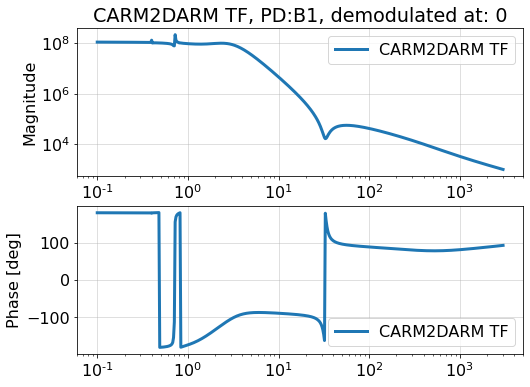

In [ ]:
plot_tf_kat(ff3, carm2darm_tf, 'CARM2DARM', kat3)

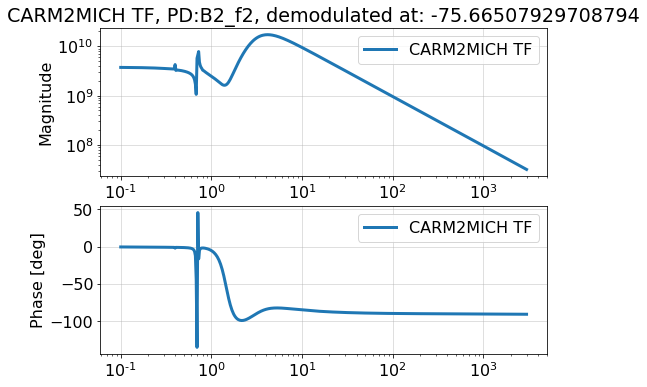

In [ ]:
plot_tf_kat(ff3, carm2mich_tf, 'CARM2MICH', kat3)

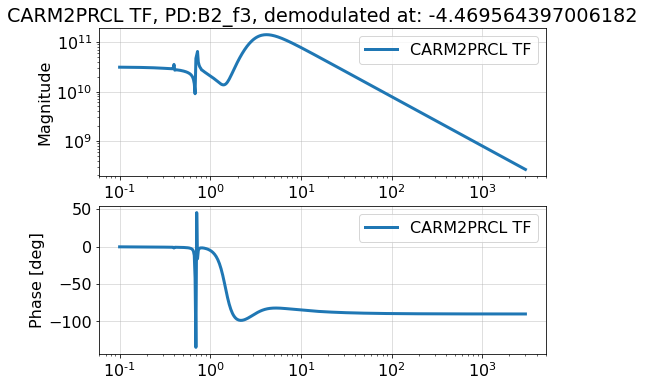

In [ ]:
plot_tf_kat(ff3, carm2prcl_tf, 'CARM2PRCL', kat3)

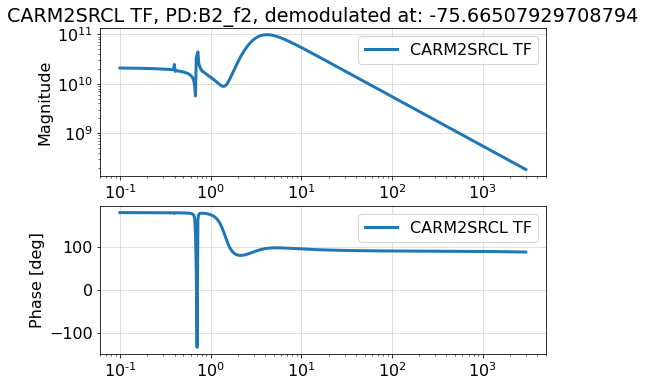

In [ ]:
plot_tf_kat(ff3, carm2srcl_tf, 'CARM2SRCL', kat3)

## Next:

    3. From MICH to any other DOF.
    
    4. From PRCL to any other DOF.
    
    5. From SRCL to any other DOF.


In [ ]:
# 3. From MICH to any other DOF.
kat3.IFO.MICH2DARM =  adv.DOF(kat3.IFO, "MICH2DARM", getattr(kat3.IFO, kat3.IFO.DARM.port.name), kat3.IFO.DARM.quad, kat3.IFO.MICH.optics, kat3.IFO.MICH.factors, kat3.IFO.MICH.scale, sigtype="z")
kat3.IFO.MICH2CARM =  adv.DOF(kat3.IFO, "MICH2CARM", getattr(kat3.IFO, kat3.IFO.CARM.port.name), kat3.IFO.CARM.quad, kat3.IFO.MICH.optics, kat3.IFO.MICH.factors, kat3.IFO.MICH.scale, sigtype="z")
kat3.IFO.MICH2PRCL =  adv.DOF(kat3.IFO, "MICH2PRCL", getattr(kat3.IFO, kat3.IFO.PRCL.port.name), kat3.IFO.PRCL.quad, kat3.IFO.MICH.optics, kat3.IFO.MICH.factors, kat3.IFO.MICH.scale, sigtype="z")
kat3.IFO.MICH2SRCL =  adv.DOF(kat3.IFO, "MICH2SRCL", getattr(kat3.IFO, kat3.IFO.SRCL.port.name), kat3.IFO.SRCL.quad, kat3.IFO.MICH.optics, kat3.IFO.MICH.factors, kat3.IFO.MICH.scale, sigtype="z")

In [ ]:
out_mich2darm = kat3.IFO.MICH2DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_mich2carm = kat3.IFO.MICH2CARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_mich2prcl = kat3.IFO.MICH2PRCL.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_mich2srcl = kat3.IFO.MICH2SRCL.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)

#ff3 = out_carm2darm.x
#darm2carm_tf = out_darm2carm['B2_f1_I_TF']
mich2darm_tf = out_mich2darm['B1_TF']
mich2carm_tf = out_mich2carm['B2_f1_I_TF']
mich2prcl_tf = out_mich2prcl['B2_f3_I_TF']
mich2srcl_tf = out_mich2srcl['B2_f2_I_TF']

### Save data:

In [ ]:
save_data('mich2darm_tf.txt', ff3, mich2darm_tf)
save_data("mich2carm_tf.txt", ff3, mich2carm_tf)
save_data("mich2prcl_tf.txt", ff3, mich2prcl_tf)
save_data("mich2srcl_tf.txt", ff3, mich2srcl_tf)

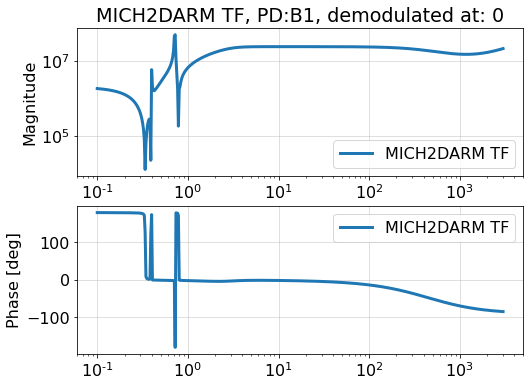

In [ ]:
plot_tf_kat(ff3, mich2darm_tf, 'MICH2DARM', kat3)

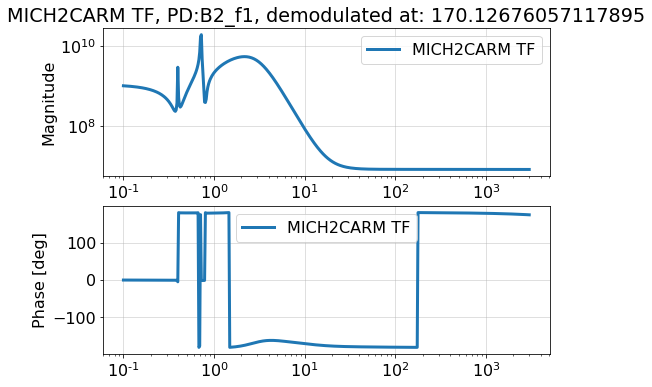

In [ ]:
plot_tf_kat(ff3, mich2carm_tf, 'MICH2CARM', kat3)

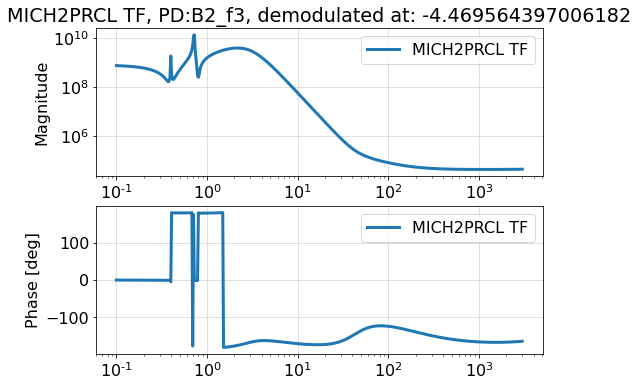

In [ ]:
plot_tf_kat(ff3, mich2prcl_tf, 'MICH2PRCL', kat3)

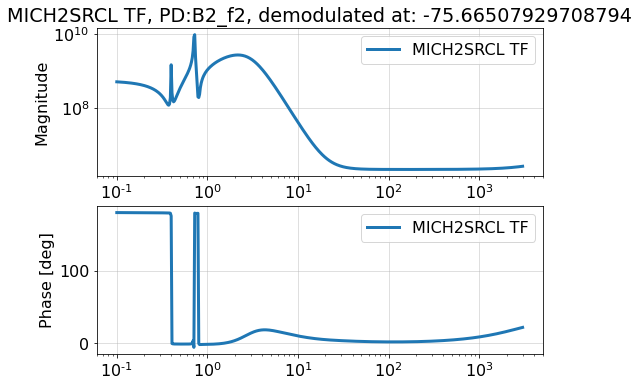

In [ ]:
plot_tf_kat(ff3, mich2srcl_tf, 'MICH2SRCL', kat3)

In [ ]:
## 4. From PRCL to any other DOF.
kat3.IFO.PRCL2DARM =  adv.DOF(kat3.IFO, "PRCL2DARM", getattr(kat3.IFO, kat3.IFO.DARM.port.name), kat3.IFO.DARM.quad, kat3.IFO.PRCL.optics, kat3.IFO.PRCL.factors, kat3.IFO.PRCL.scale, sigtype="z")
kat3.IFO.PRCL2CARM =  adv.DOF(kat3.IFO, "PRCL2CARM", getattr(kat3.IFO, kat3.IFO.CARM.port.name), kat3.IFO.CARM.quad, kat3.IFO.PRCL.optics, kat3.IFO.PRCL.factors, kat3.IFO.PRCL.scale, sigtype="z")
kat3.IFO.PRCL2MICH =  adv.DOF(kat3.IFO, "PRCL2MICH", getattr(kat3.IFO, kat3.IFO.MICH.port.name), kat3.IFO.MICH.quad, kat3.IFO.PRCL.optics, kat3.IFO.PRCL.factors, kat3.IFO.PRCL.scale, sigtype="z")
kat3.IFO.PRCL2SRCL =  adv.DOF(kat3.IFO, "PRCL2SRCL", getattr(kat3.IFO, kat3.IFO.SRCL.port.name), kat3.IFO.SRCL.quad, kat3.IFO.PRCL.optics, kat3.IFO.PRCL.factors, kat3.IFO.PRCL.scale, sigtype="z")

In [ ]:
out_prcl2darm = kat3.IFO.PRCL2DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_prcl2carm = kat3.IFO.PRCL2CARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_prcl2mich = kat3.IFO.PRCL2MICH.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_prcl2srcl = kat3.IFO.PRCL2SRCL.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)

#ff3 = out_carm2darm.x
prcl2darm_tf = out_prcl2darm['B1_TF']
prcl2carm_tf = out_prcl2carm['B2_f1_I_TF']
#prcl2prcl_tf = out_prcl2prcl['B2_f3_I_TF']
prcl2mich_tf = out_prcl2mich['B2_f2_Q_TF']
prcl2srcl_tf = out_prcl2srcl['B2_f2_I_TF']

### Save data:

In [ ]:
save_data('prcl2darm_tf.txt', ff3, prcl2darm_tf)
save_data("prcl2carm_tf.txt", ff3, prcl2carm_tf)
save_data("prcl2mich_tf.txt", ff3, prcl2mich_tf)
save_data("prcl2srcl_tf.txt", ff3, prcl2srcl_tf)

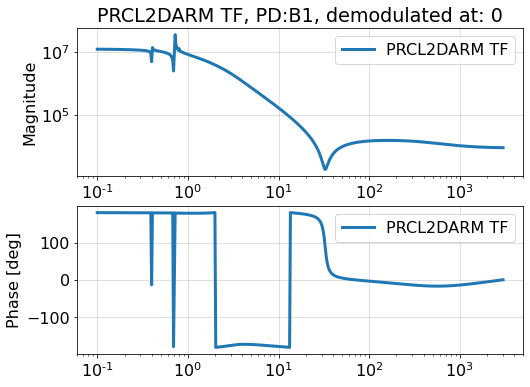

In [ ]:
plot_tf_kat(ff3, prcl2darm_tf, 'PRCL2DARM', kat3)

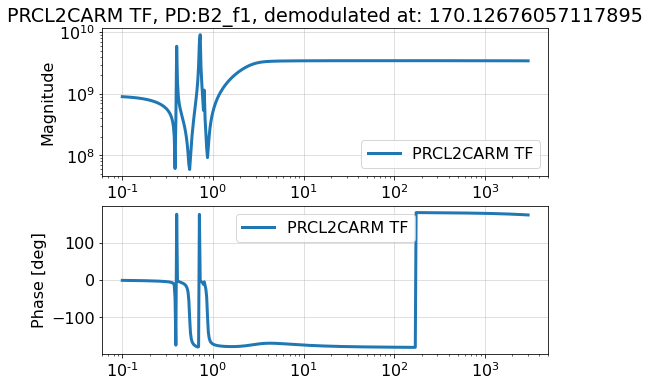

In [ ]:
plot_tf_kat(ff3, prcl2carm_tf, 'PRCL2CARM', kat3)

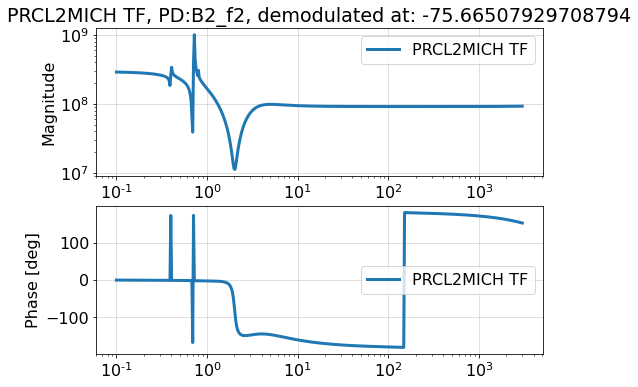

In [ ]:
plot_tf_kat(ff3, prcl2mich_tf, 'PRCL2MICH', kat3)

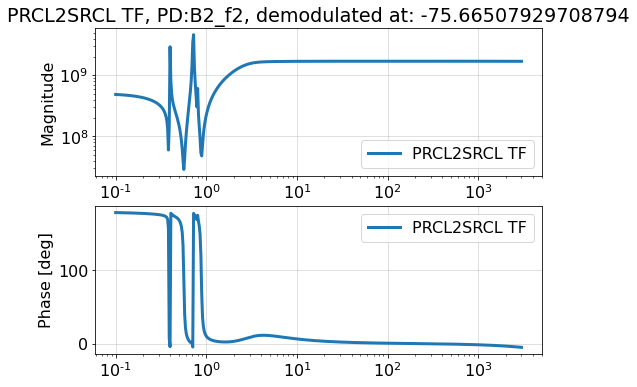

In [ ]:
plot_tf_kat(ff3, prcl2srcl_tf, 'PRCL2SRCL', kat3)

In [ ]:
## 4. From SRCL to any other DOF.
kat3.IFO.SRCL2DARM =  adv.DOF(kat3.IFO, "SRCL2DARM", getattr(kat3.IFO, kat3.IFO.DARM.port.name), kat3.IFO.DARM.quad, kat3.IFO.SRCL.optics, kat3.IFO.SRCL.factors, kat3.IFO.SRCL.scale, sigtype="z")
kat3.IFO.SRCL2CARM =  adv.DOF(kat3.IFO, "SRCL2CARM", getattr(kat3.IFO, kat3.IFO.CARM.port.name), kat3.IFO.CARM.quad, kat3.IFO.SRCL.optics, kat3.IFO.SRCL.factors, kat3.IFO.SRCL.scale, sigtype="z")
kat3.IFO.SRCL2MICH =  adv.DOF(kat3.IFO, "SRCL2MICH", getattr(kat3.IFO, kat3.IFO.MICH.port.name), kat3.IFO.MICH.quad, kat3.IFO.SRCL.optics, kat3.IFO.SRCL.factors, kat3.IFO.SRCL.scale, sigtype="z")
kat3.IFO.SRCL2PRCL =  adv.DOF(kat3.IFO, "SRCL2PRCL", getattr(kat3.IFO, kat3.IFO.PRCL.port.name), kat3.IFO.PRCL.quad, kat3.IFO.SRCL.optics, kat3.IFO.SRCL.factors, kat3.IFO.SRCL.scale, sigtype="z")

In [ ]:
out_srcl2darm = kat3.IFO.SRCL2DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_srcl2carm = kat3.IFO.SRCL2CARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_srcl2mich = kat3.IFO.SRCL2MICH.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_srcl2prcl = kat3.IFO.SRCL2PRCL.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)

#ff3 = out_carm2darm.x
srcl2darm_tf = out_srcl2darm['B1_TF']
srcl2carm_tf = out_srcl2carm['B2_f1_I_TF']
#prcl2prcl_tf = out_prcl2prcl['B2_f3_I_TF']
srcl2mich_tf = out_srcl2mich['B2_f2_Q_TF']
#prcl2srcl_tf = out_prcl2srcl['B2_f2_I_TF']
srcl2prcl_tf = out_srcl2prcl['B2_f3_I_TF']

### Save data:

In [ ]:
save_data('srcl2darm_tf.txt', ff3, srcl2darm_tf)
save_data("srcl2carm_tf.txt", ff3, srcl2carm_tf)
save_data("srcl2mich_tf.txt", ff3, srcl2mich_tf)
save_data("srcl2prcl_tf.txt", ff3, srcl2prcl_tf)

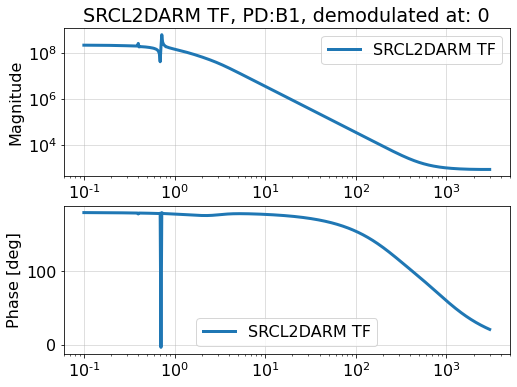

In [ ]:
plot_tf_kat(ff3, srcl2darm_tf, 'SRCL2DARM', kat3)

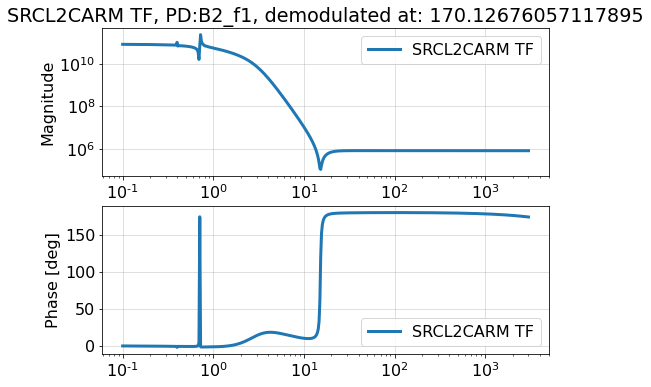

In [ ]:
plot_tf_kat(ff3, srcl2carm_tf, 'SRCL2CARM', kat3)

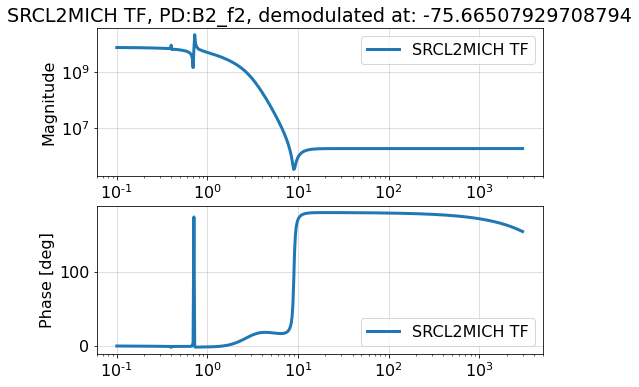

In [ ]:
plot_tf_kat(ff3, srcl2mich_tf, 'SRCL2MICH', kat3)

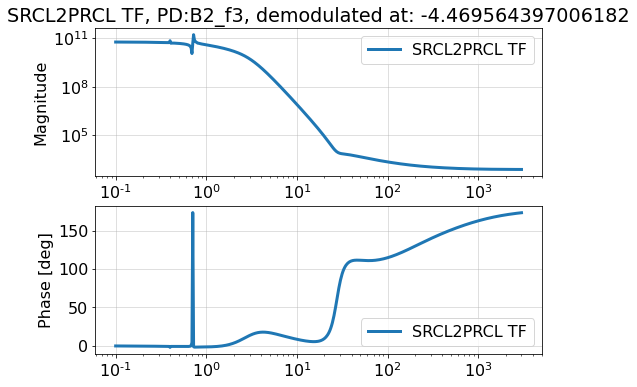

In [ ]:
plot_tf_kat(ff3, srcl2prcl_tf, 'SRCL2PRCL', kat3)

### ---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ---------------------- ----------------------

## Compute TFs to B1 moving one mirror at a time.

In [ ]:
# Check mirrors:
kat3.IFO.mirrors

['NE',
 'NI',
 'NIAR',
 'WE',
 'WI',
 'WIAR',
 'PR',
 'PRAR',
 'SR',
 'SRAR',
 'BS',
 'BSAR1',
 'BSAR2']

In [ ]:
# 1. From one mirror to DARM sensor 
# Compute TFs for PR, BS, SR, NE, NI, WE, WI.
kat3.IFO.PR2DARM =  adv.DOF(kat3.IFO, "PR2DARM", kat3.IFO.B1, "", ['PR'], [-1], 100, sigtype="z")
kat3.IFO.BS2DARM =  adv.DOF(kat3.IFO, "BS2DARM", kat3.IFO.B1, "", ['BS'], [-1], 100, sigtype="z")
kat3.IFO.SR2DARM =  adv.DOF(kat3.IFO, "SR2DARM", kat3.IFO.B1, "", ['SR'], [-1], 100, sigtype="z")

kat3.IFO.NI2DARM =  adv.DOF(kat3.IFO, "NI2DARM", kat3.IFO.B1, "", ['NI'], [-1], 1.0, sigtype="z")
kat3.IFO.NE2DARM =  adv.DOF(kat3.IFO, "NE2DARM", kat3.IFO.B1, "", ['NE'], [-1], 1.0, sigtype="z")
kat3.IFO.WI2DARM =  adv.DOF(kat3.IFO, "WI2DARM", kat3.IFO.B1, "", ['WI'], [-1], 1.0, sigtype="z")
kat3.IFO.WE2DARM =  adv.DOF(kat3.IFO, "WE2DARM", kat3.IFO.B1, "", ['WE'], [-1], 1.0, sigtype="z")

In [ ]:
out_pr2darm = kat3.IFO.PR2DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_bs2darm = kat3.IFO.BS2DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_sr2darm = kat3.IFO.SR2DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)

out_ni2darm = kat3.IFO.NI2DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_ne2darm = kat3.IFO.NE2DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_wi2darm = kat3.IFO.WI2DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)
out_we2darm = kat3.IFO.WE2DARM.scan_f(linlog='log', lower=1e-1, upper=3e3, steps = 500)

In [ ]:
ff4 = out_pr2darm.x
pr2darm_tf = out_pr2darm['B1_TF']
bs2darm_tf = out_bs2darm['B1_TF']
sr2darm_tf = out_sr2darm['B1_TF']

ni2darm_tf = out_ni2darm['B1_TF']
ne2darm_tf = out_ne2darm['B1_TF']
wi2darm_tf = out_wi2darm['B1_TF']
we2darm_tf = out_we2darm['B1_TF']

In [ ]:
### Save data:

In [ ]:
save_data('pr2darm_tf.txt', ff4, pr2darm_tf)
save_data('bs2darm_tf.txt', ff4, bs2darm_tf)
save_data('sr2darm_tf.txt', ff4, sr2darm_tf)

save_data('ni2darm_tf.txt', ff4, ni2darm_tf)
save_data('ne2darm_tf.txt', ff4, ne2darm_tf)
save_data('wi2darm_tf.txt', ff4, wi2darm_tf)
save_data('we2darm_tf.txt', ff4, we2darm_tf)

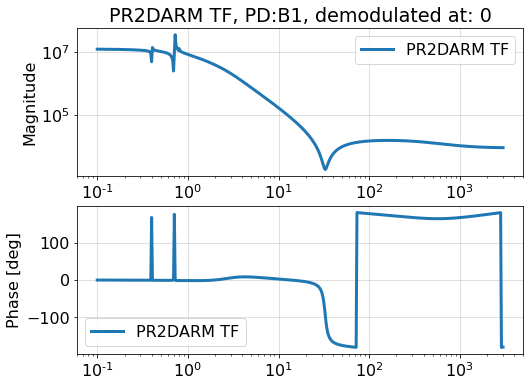

In [ ]:
plot_tf_kat(ff4, pr2darm_tf, 'PR2DARM', kat3)

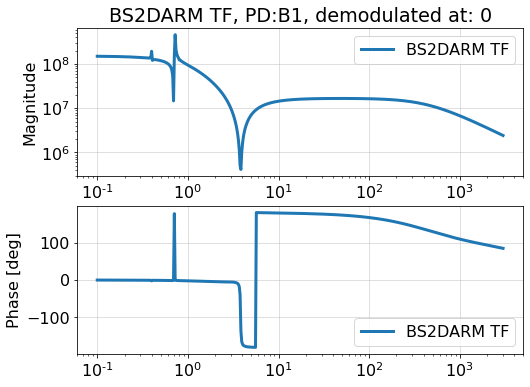

In [ ]:
plot_tf_kat(ff4, bs2darm_tf, 'BS2DARM', kat3)

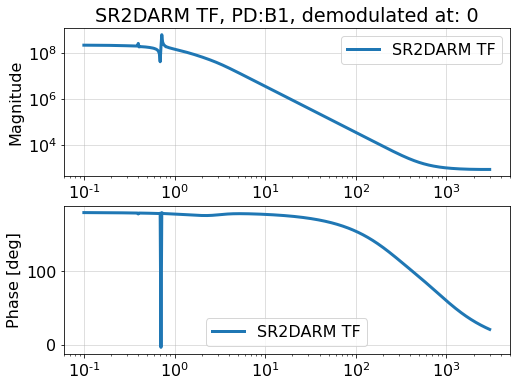

In [ ]:
plot_tf_kat(ff4, sr2darm_tf, 'SR2DARM', kat3)

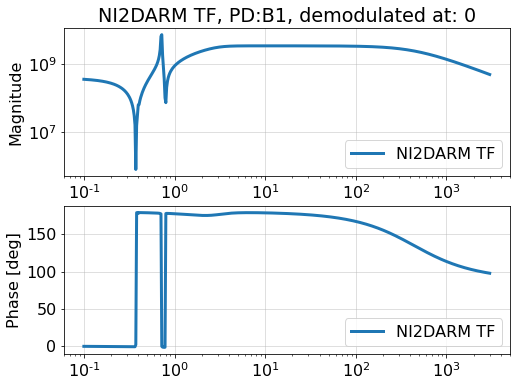

In [ ]:
plot_tf_kat(ff4, ni2darm_tf, 'NI2DARM', kat3)

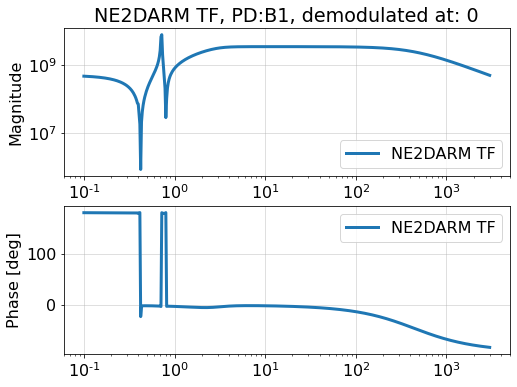

In [ ]:
plot_tf_kat(ff4, ne2darm_tf, 'NE2DARM', kat3)

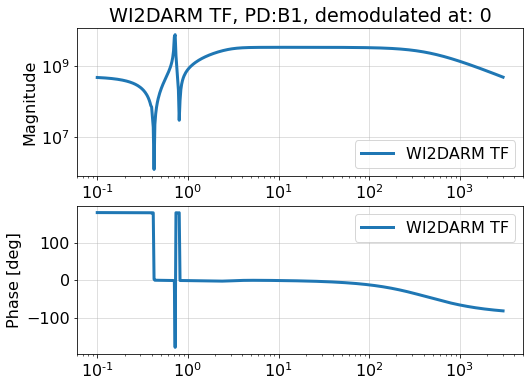

In [ ]:
plot_tf_kat(ff4, wi2darm_tf, 'WI2DARM', kat3)

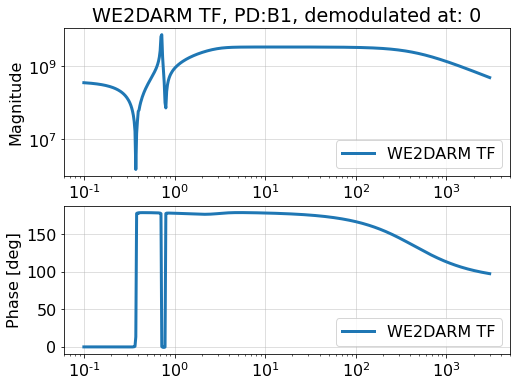

In [ ]:
plot_tf_kat(ff4, we2darm_tf, 'WE2DARM', kat3)